Goal:  identify which factors predict future user adoption.  

Approach:  
* EDA, data cleaning
* feature engineering
* predictive modeling

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [3]:
#load data
users=pd.read_csv('takehome_users.csv',encoding='ISO-8859-1',parse_dates=[1])
engagement=pd.read_csv('takehome_user_engagement.csv',parse_dates=[0])
engagement=engagement.set_index('time_stamp')

In [4]:
print(users.shape)
users.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
engagement.sort_values(['user_id','time_stamp']).head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [6]:
users.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

In [7]:
#convert last_session_creation_time to a datetime
#assume nulls are users who created accounts but never had additional sessions, set last_session to account creation datetime
import datetime
users.last_session_creation_time = users.apply(
    lambda row: datetime.datetime.fromtimestamp(row.last_session_creation_time) 
    if pd.notnull(row.last_session_creation_time) 
    else row.creation_time, 
    axis=1)

In [8]:
#derive adopted user indicator (target)

# visits by user in 7 days prior to index date
weekly_count=engagement.groupby('user_id')['visited'].rolling('7d').sum()# = engagement.groupby([pd.Grouper(key='time_stamp',freq='W'),'user_id']).count()
weekly_count=weekly_count.reset_index()

# get weekly count max per user, then create adopted user class as max>=3
user_max_count=weekly_count.groupby('user_id')['visited'].max()
user_max_count.rename('max_weekly_visits',inplace=True)

adopted_user=(user_max_count>=3)*1
adopted_user.rename('is_adopted_user',inplace=True);

In [9]:
#join engagment stats back to original table, set nulls to zero (no visits)
users.rename({'object_id':'user_id'},inplace=True,axis=1)
users=users.set_index('user_id')
users_all=users.join(adopted_user).join(user_max_count)
users_all['is_adopted_user']=users_all['is_adopted_user'].fillna(0)
users_all['max_weekly_visits']=users_all['max_weekly_visits'].fillna(0)


In [10]:
#overall adoption rate and counts
users_all['is_adopted_user'].mean()

0.1335

In [123]:
users_all['is_adopted_user'].value_counts()

0.0    10398
1.0     1602
Name: is_adopted_user, dtype: int64

In [83]:
# functions to evaluate categorical variables

#chi square test
#are we likely to see this difference in counts by chance?
from scipy.stats import chi2_contingency
def chi_square(ctable):
    chi2, p, dof, ex = chi2_contingency(ctable)
    ret_dict={'chi2':chi2,'p':p,'dof':dof,'ex':ex}
    return ret_dict

#function to cross tab and plot distributions as counts and proportions
def eval_factor(df,binary_field,outcome_field):
    xtab=pd.crosstab(index=df[binary_field],columns=df[outcome_field])
    xtab['adoption_rate']=xtab.apply(lambda row: row[1.0]/(row[1.0]+row[0.0]),axis=1)
    xtab['non_adoption_rate']=1-xtab['adoption_rate']
    chi2=chi_square(xtab.iloc[:,:2])
    print('Chi-square statistic: {}, P-value: {}'.format(chi2['chi2'],chi2['p']))
    #generate plots
    fig,ax=plt.subplots(1,2,figsize=[15,6])
    xtab.iloc[:,:2].plot.bar(stacked=True,ax=ax[0])
    xtab.iloc[:,[3,2]].plot.bar(stacked=True,ax=ax[1]).legend(bbox_to_anchor=(1,1))
    ax[0].set_ylabel('Number of users')
    ax[1].set_ylabel('Proportion of users')
    ax[0].set_title('Counts of '+binary_field)
    ax[1].set_title('Proportions of '+binary_field)
    return xtab

#permutation test - two proportions
#how likely to observe this difference in proportion of adopted users?
def permutation_difference_in_proportions_test(df,binary_field,outcome_field,n=1000):
    #compute original difference in proportions, counts per category
    rates=df.groupby(binary_field)[outcome_field].agg(['count',lambda x: x.sum()/x.count()])
    rate_diff=np.abs(rates.loc[0][1]-rates.loc[1][1])
    n_all=df.shape[0]
    n_A=rates.loc[0][0].astype(int)
    n_B=n_all-n_A
    
    #set up permutations
    results=np.empty(n)
    orig_outcomes=df[outcome_field].values
    
    for n in range(n):
        permuted=np.random.permutation(orig_outcomes)
        draw_A=permuted[:n_A]
        draw_B=permuted[n_A:]
        results[n]=(np.sum(draw_A)/n_A)-(np.sum(draw_B)/n_B)
    
    #two sided test results
    p=np.sum(np.logical_or(results<-rate_diff,results>rate_diff))/n
    
    return p 
    

Chi-square statistic: 9.025572948110002, P-value: 0.0026622846583239388
Permutation test p: 0.0020


is_adopted_user,0.0,1.0,adoption_rate,non_adoption_rate
invited,,,,
0,4894,689,0.123410,0.876590
1,5504,913,0.142278,0.857722


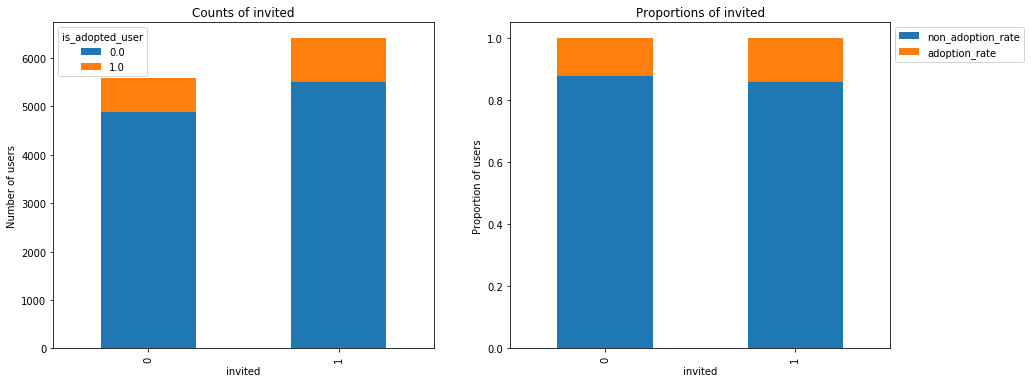

In [97]:
#derive flag to indicate user was invited 
#assume nulls indicate no invitiation
users_all['invited']=pd.notnull(users_all['invited_by_user_id'])*1
invited_binned=eval_factor(users_all,'invited','is_adopted_user')

p=permutation_difference_in_proportions_test(users_all,'invited','is_adopted_user')
print('Permutation test p: {:0.4f}'.format(p))

display(invited_binned)
#--> We see a small (2%) but statistically significant increase in engagement for invited users
#--> this flag appears equivalent combination of guest_invite or organizational_invite

Chi-square statistic: 53.27785957806963, P-value: 2.895516997988619e-13
Permutation test p: 0.0000


is_adopted_user,0.0,1.0,adoption_rate,non_adoption_rate
invited_by_adopted,,,,
0.0,9533,1378,0.126295,0.873705
1.0,865,224,0.205693,0.794307


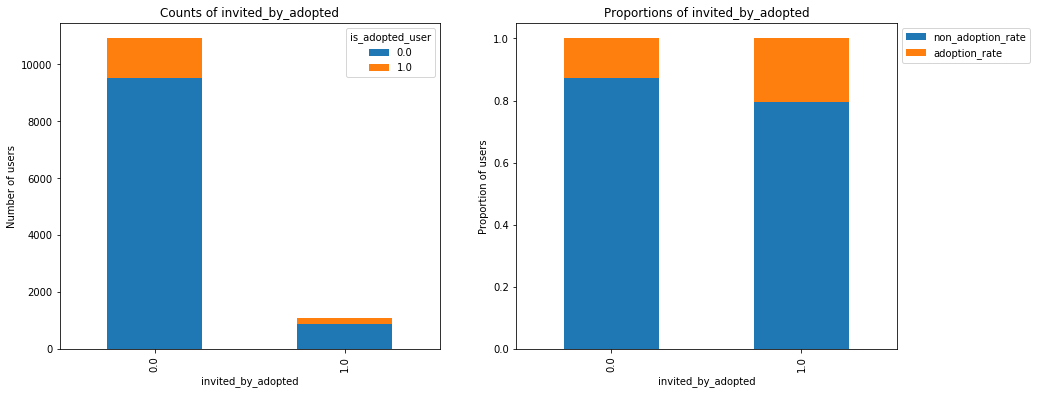

In [103]:
#does being invited by an adopted user predict adoption?
users_all['invited_by_adopted']=users_all['invited_by_user_id'].map(users_all['is_adopted_user']).fillna(0)
invite_by_adopted_binned=eval_factor(users_all,'invited_by_adopted','is_adopted_user')
p=permutation_difference_in_proportions_test(users_all,'invited_by_adopted','is_adopted_user')
print('Permutation test p: {:0.4f}'.format(p))

display(invite_by_adopted_binned)
#--> looks more informative, distinguishes 13% vs 21%

In [17]:
#do we see any correlations between the parameters and adoption?
#pearson coeff for two binaries is valid https://en.wikipedia.org/wiki/Phi_coefficient

users_all[['creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'invited',
       'is_adopted_user']].corr()
#--> no

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited,is_adopted_user
opted_in_to_mailing_list,1.000000,0.483529,0.006934,0.008097
enabled_for_marketing_drip,0.483529,1.000000,0.002216,0.004653
invited,0.006934,0.002216,1.000000,0.027671
is_adopted_user,0.008097,0.004653,0.027671,1.000000


Chi-square statistic: 92.28463976593648, P-value: 4.305821709002406e-19


is_adopted_user,0.0,1.0,adoption_rate,non_adoption_rate
creation_source,,,,
GUEST_INVITE,1803,360,0.166436,0.833564
ORG_INVITE,3701,553,0.129995,0.870005
PERSONAL_PROJECTS,1947,164,0.077688,0.922312
SIGNUP,1794,293,0.140393,0.859607
SIGNUP_GOOGLE_AUTH,1153,232,0.167509,0.832491


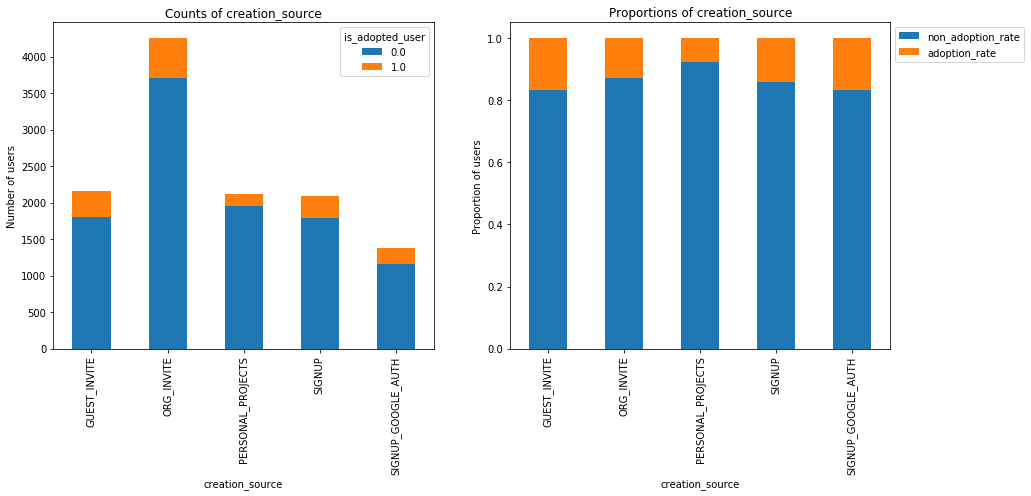

In [93]:
#look at creation source
creation_src_binned=eval_factor(users_all,'creation_source','is_adopted_user')
display(creation_src_binned)
# --> possibly useful, relatively low adoption for personal projects

Chi-square statistic: 0.7327718655131716, P-value: 0.3919861918708256
Permutation test p: 0.3944


is_adopted_user,0.0,1.0,adoption_rate,non_adoption_rate
opted_in_to_mailing_list,,,,
0,7818,1188,0.131912,0.868088
1,2580,414,0.138277,0.861723


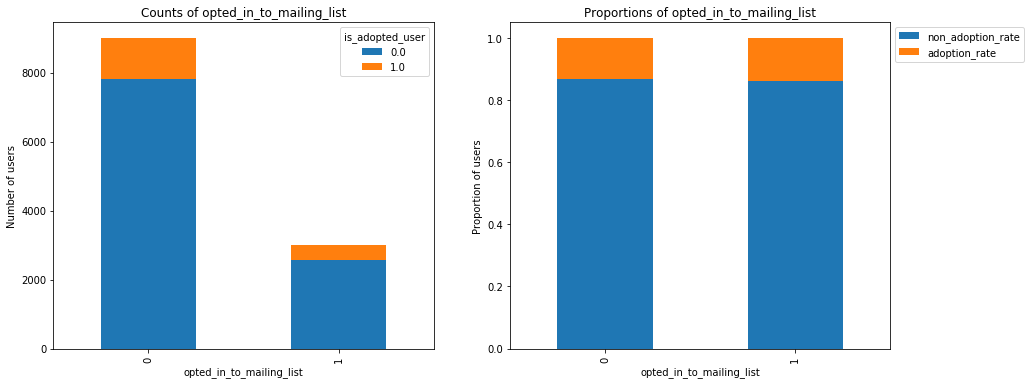

In [99]:
#look at marketing features
optin_binned=eval_factor(users_all,'opted_in_to_mailing_list','is_adopted_user')

p=permutation_difference_in_proportions_test(users_all,'opted_in_to_mailing_list','is_adopted_user')
print('Permutation test p: {:0.4f}'.format(p))
display(optin_binned)
# --> not as useful, chi-square | permutation results not significant

Chi-square statistic: 0.22279770974709384, P-value: 0.6369164225605993
Permutation test p: 0.5926


is_adopted_user,0.0,1.0,adoption_rate,non_adoption_rate
enabled_for_marketing_drip,,,,
0,8852,1356,0.132837,0.867163
1,1546,246,0.137277,0.862723


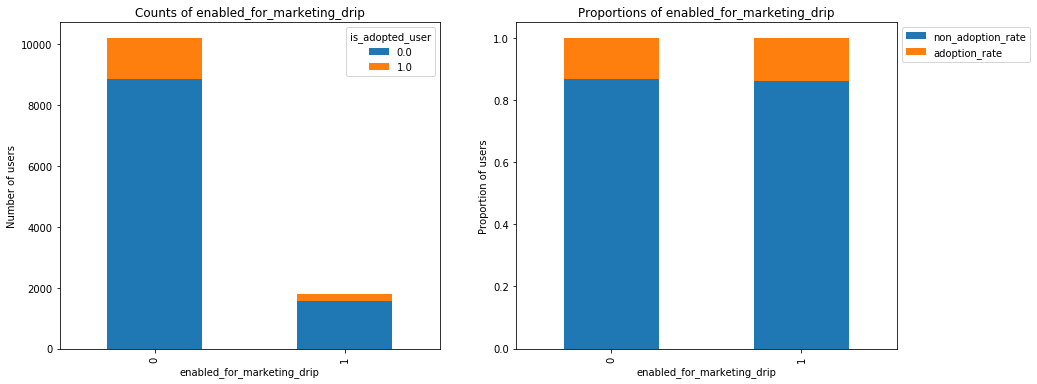

In [100]:
mktg_binned=eval_factor(users_all,'enabled_for_marketing_drip','is_adopted_user')
p=permutation_difference_in_proportions_test(users_all,'enabled_for_marketing_drip','is_adopted_user')
print('Permutation test p: {:0.4f}'.format(p))
display(mktg_binned)
# --> again doesn't look promising

In [ ]:
#look at organizational factors

In [104]:
#derive domain from email
#how many organizations?
#how many domains?
print('number of organizations: {}'.format(len(users_all.org_id.unique())))
users_all['domain']=users_all.email.str.extract(pat='@(\w+)')
print('number of domains: {}'.format(len(users_all.domain.unique())))

number of organizations: 417
number of domains: 1184


In [105]:
#look at variation in adoption rate between domains
dom_grp=users_all.groupby('domain')['is_adopted_user'].agg(['mean','count'])
dom_grp.columns=['adopted_frac','n_users']
dom_grp.sort_values('adopted_frac',ascending=False).head(25)
#dom_grp['adopted_frac'].hist(bins=20)

dom_grp.loc[dom_grp['n_users']>1].sort_values('adopted_frac') #none
#-->there are only six domains with more than two users.  gmail and hotmail have slightly higher adoption rates.
#will create indicators of membership in these domains, and 'other'

,adopted_frac,n_users
domain,,
oqpze,0.000000,2
qgjbc,0.000000,2
rerwl,0.000000,2
xvnbr,0.000000,2
xybhi,0.000000,2
yahoo,0.106661,2447
cuvox,0.114809,1202
gustr,0.121289,1179
jourrapide,0.129468,1259


Chi-square statistic: 44.388734374319675, P-value: 6.189426120244182e-08


is_adopted_user,0.0,1.0,adoption_rate,non_adoption_rate
domain,,,,
cuvox,1064,138,0.114809,0.885191
gmail,3019,543,0.152442,0.847558
gustr,1036,143,0.121289,0.878711
hotmail,968,197,0.169099,0.830901
jourrapide,1096,163,0.129468,0.870532
other,1029,157,0.132378,0.867622
yahoo,2186,261,0.106661,0.893339


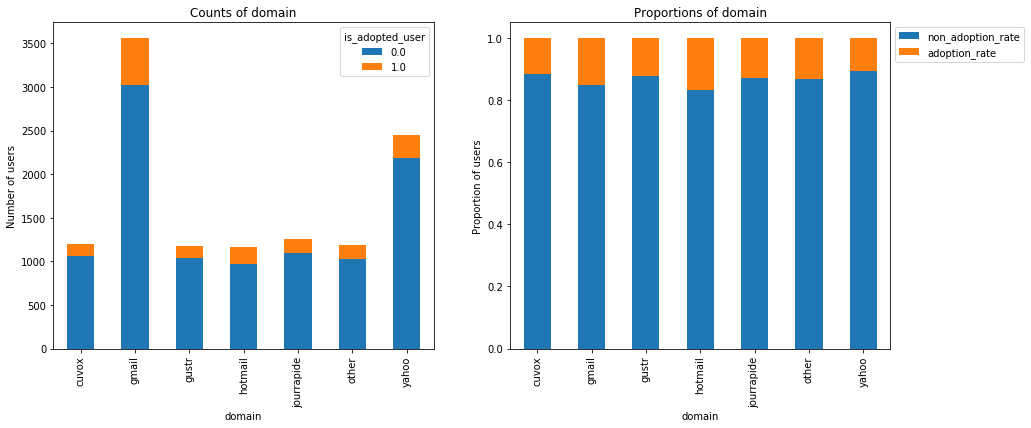

In [106]:
#new domain flag
top_domains=dom_grp.loc[dom_grp.n_users>2].index.tolist()
users_all['domain']=users_all['domain'].apply(lambda x: x if x in(top_domains) else 'other')
domain_binned=eval_factor(users_all,'domain','is_adopted_user')
domain_binned

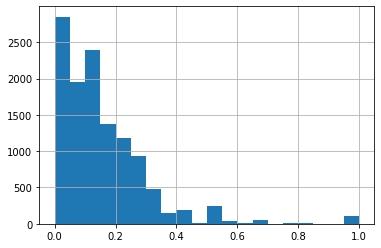

In [120]:
#does prior user adoption behavior at an organization affect future adoption?
#look at variation in adoption rate and adoption counts between organizations
#calculate expanding mean as time series
users_ts=users_all[['creation_time','org_id','is_adopted_user']].sort_values('creation_time')
users_ts['prior_org_adoption_rate']=users_ts.groupby('org_id')['is_adopted_user'].apply(lambda x:x.shift(1).expanding().mean()).fillna(0)
users_ts['prior_org_n_adopted_users']=users_ts.groupby('org_id')['is_adopted_user'].apply(lambda x:x.shift(1).expanding().sum()).fillna(0)
users_ts['prior_org_n_users']=users_ts.groupby('org_id')['is_adopted_user'].apply(lambda x:x.shift(1).expanding().count()).fillna(0)
users_ts.loc[users_ts.org_id==6].values

users_ts['prior_org_adoption_rate'].hist(bins=20)

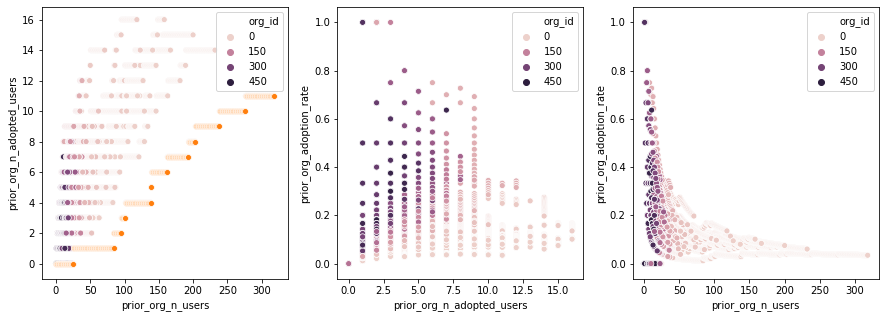

In [126]:
#look at relationship between organization size and adoption
fig, ax=plt.subplots(1,3,figsize=[15,5])
sns.scatterplot(y='prior_org_adoption_rate',x='prior_org_n_adopted_users',hue='org_id',ax=ax[1],data=users_ts)
sns.scatterplot(y='prior_org_n_adopted_users',x='prior_org_n_users',hue='org_id',ax=ax[0],data=users_ts)
sns.scatterplot(y='prior_org_adoption_rate',x='prior_org_n_users',hue='org_id',ax=ax[2],data=users_ts)
#organization 0 has a much lower adoption rate
sns.scatterplot(y='prior_org_n_adopted_users',x='prior_org_n_users',ax=ax[0],data=users_ts.loc[users_ts.org_id==0])

#first plot:  growth in user adoptions roughly linear with user base
#second plot:  once an organization reaches 10 adopted users the adoption rate goes down
#third plot:  adoption rates are highest for organizations with small number of usrs

In [127]:
#re-join organizational factors to main table
users_all=pd.merge(users_all,users_ts[['prior_org_adoption_rate',
       'prior_org_n_adopted_users', 'prior_org_n_users']],left_index=True,right_index=True)


,prior_org_adoption_rate,prior_org_n_adopted_users,prior_org_n_users
is_adopted_user,,,
0.0,0.149075,3.145413,28.470764
1.0,0.161032,2.301498,17.860175


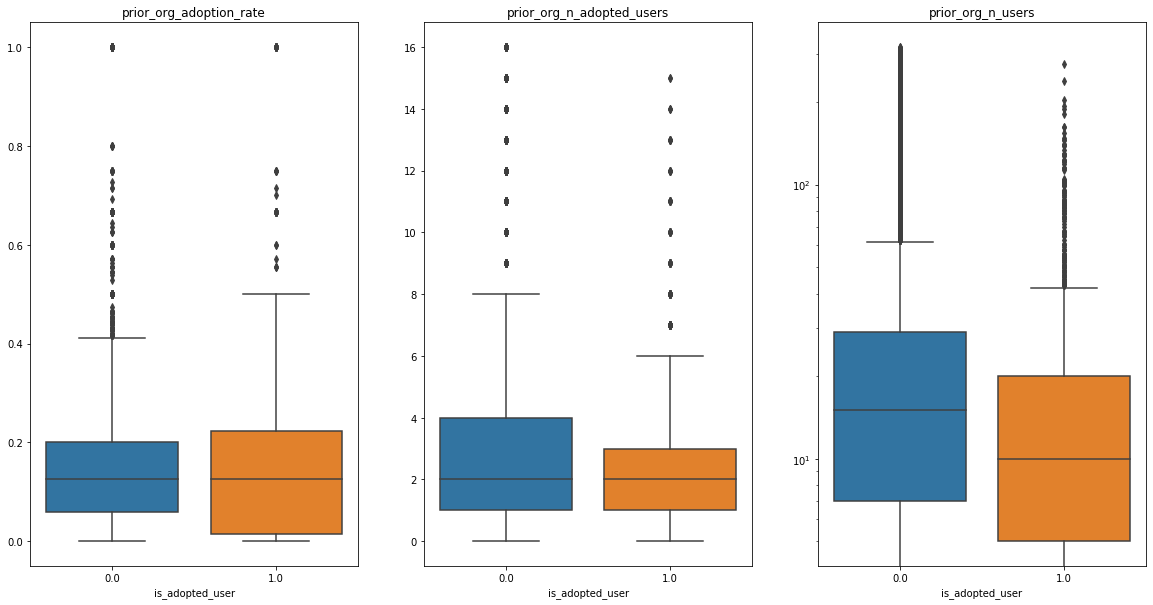

In [178]:
#look at relationship between continuous factors and individual adoption
numerics=['prior_org_adoption_rate','prior_org_n_adopted_users','prior_org_n_users']
nplots=len(numerics)
fig,axs=plt.subplots(1,nplots,figsize=[20,10])
for p in range(nplots):
    ax=axs[p]
    sns.boxplot(x='is_adopted_user',y=numerics[p],data=users_all,ax=ax)
    if p in (2,3):
        ax.set_yscale('log')
    ax.set_ylabel('')
    ax.set_title(numerics[p])
users_all.groupby('is_adopted_user')[numerics].mean()


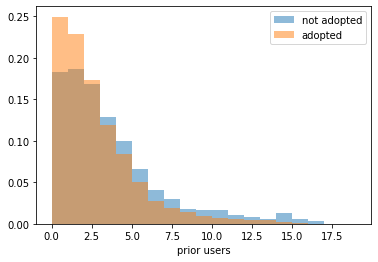

In [231]:
# will focus on number of adopted users - distribution plots doesn't suggest this is a big differentiator
#not normally distributed
plt.hist(users_all.loc[users_all.is_adopted_user==0,'prior_org_n_adopted_users'],bins=range(20),density=True,alpha=0.5,label='not adopted')
plt.hist(users_all.loc[users_all.is_adopted_user==1,'prior_org_n_adopted_users'],bins=range(20),density=True,alpha=0.5,label='adopted')
plt.xlabel('prior users')
plt.legend();
#the two pdfs switch around 2 users but mostly the same

In [217]:
#Let's build a model to see how well we can predict user adoption
#since we saw some nonlinear effects, will use non-linear method (trees)
X=pd.concat([users_all[['invited_by_adopted','prior_org_n_adopted_users']],pd.get_dummies(users_all['creation_source']),pd.get_dummies(users_all['domain'])],axis=1)
y=users_all['is_adopted_user']#'org_adopted_rate', 'n_org_adopted', 'n_org_users',

In [218]:
from sklearn.ensemble import GradientBoostingClassifier#,RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split

In [219]:
#split data into train and test, stratify=y to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)

#rebalance the classes in X_train,y_train by oversampling
X_train_targ0=X_train.loc[y_train==0]
X_train_targ1=X_train.loc[y_train==1]
class0_size=X_train_targ0.shape[0]
X_train_targ1_oversampled=X_train_targ1.sample(n=class0_size,replace=True)

X_train_oversampled=pd.concat([X_train_targ0,X_train_targ1_oversampled],axis=0)
y_train_oversampled=pd.Series(np.append(np.zeros(class0_size),np.ones(class0_size)))

In [220]:
gbc=GradientBoostingClassifier()
gbc.fit(X_train_oversampled,y_train_oversampled)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [221]:
def evaluate_classifier(classifier,X,y):
    pred_y=classifier.predict(X)
    pred_y_prob = classifier.predict_proba(X)[:,1]
    print(confusion_matrix(y,pred_y))
    print('\n')
    print(classification_report(y,pred_y))
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y, pred_y_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    #output scores as dict
    roc_auc=roc_auc_score(y,pred_y_prob)
    acc=accuracy_score(y,pred_y)
    
    #print auc to screen
    print('AUC: {:.3f}'.format(roc_auc))

    return({'model':type(classifier).__name__,'AUC':roc_auc,'accuracy':acc})

[[1827 1292]
 [ 207  274]]


              precision    recall  f1-score   support

         0.0       0.90      0.59      0.71      3119
         1.0       0.17      0.57      0.27       481

    accuracy                           0.58      3600
   macro avg       0.54      0.58      0.49      3600
weighted avg       0.80      0.58      0.65      3600



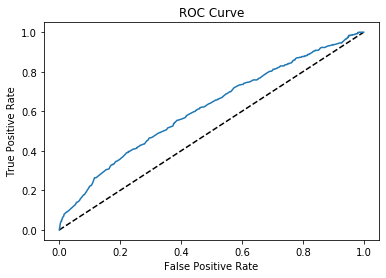

AUC: 0.613


In [222]:
out=evaluate_classifier(gbc,X_test,y_test)


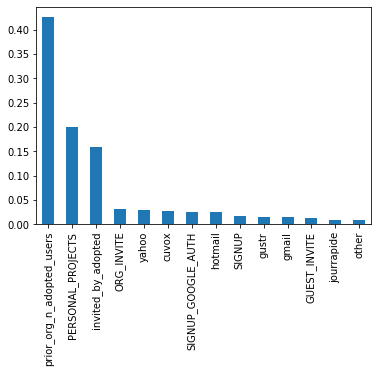

In [223]:
#result:  not a strong classifier
#what features were most important?
result=pd.Series(index=X_train.columns,data=gbc.feature_importances_).sort_values(ascending=False)
result.plot.bar()